--- 1. Loading Data ---
Original data points: 10130

--- 2. Data Cleaning & Preprocessing (Strategy: Impute Wildfire NaNs) ---
Dropping rows with NA in critical columns: ['PCT_PRICE_CHANGE (%)', 'HOME_PRICE', 'YEAR']...
Data points after dropping NAs in critical columns: 10130
Number of rows dropped based on critical columns: 0
Imputing NaN in 'FIRE_EXPOSED' with 0.
Imputing other wildfire features with 0...
  Imputed 8750 NaNs in 'NUM_FIRES' with 0.
  Imputed 8750 NaNs in 'TOTAL_ACRES_BURNED_IN_ZIP' with 0.
  Imputed 8769 NaNs in 'AVG_FIRE_DURATION_DAYS' with 0.
  Imputed 8750 NaNs in 'MAX_PCT_ZIP_BURNED' with 0.
  Imputed 8750 NaNs in 'ANY_MAJOR_FIRE' with 0.
Final data points after cleaning/imputation: 10130

--- 3. Feature Engineering: One-Hot Encoding ---
Numerical features: ['TOTAL_ACRES_BURNED_IN_ZIP', 'HOME_PRICE', 'MAX_PCT_ZIP_BURNED', 'AVG_FIRE_DURATION_DAYS', 'NUM_FIRES', 'FIRE_EXPOSED', 'ANY_MAJOR_FIRE']
Categorical features to encode: ['YEAR']
  - Unique values in 'YEAR': 

/var/folders/_5/g20j99hd5j91r849_d_zgb040000gn/T/ipykernel_47060/3497759832.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_plot, palette="viridis")


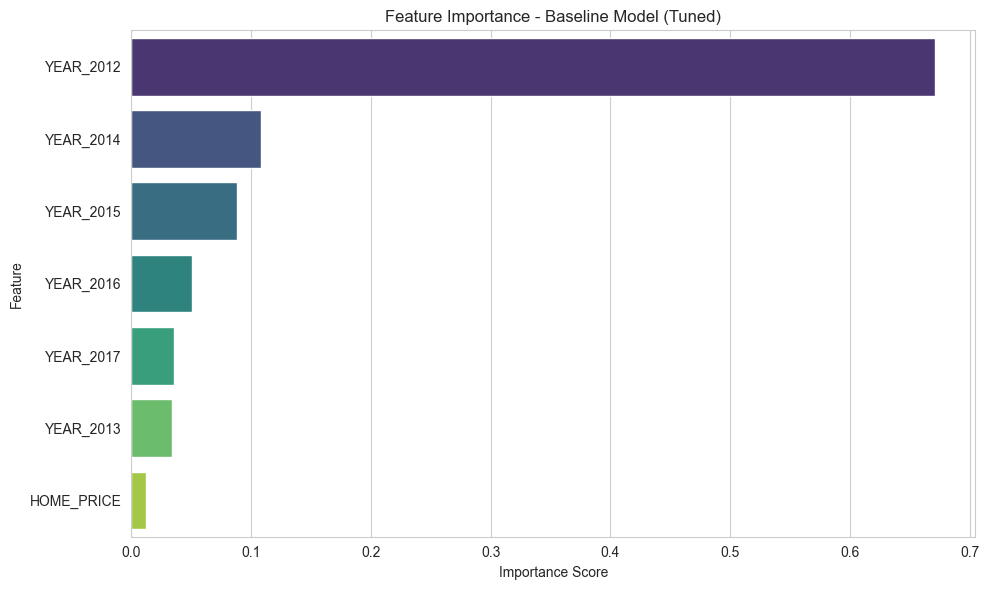


--- 5b. Full Model (All Features) ---
Tuning Full Model...
Fitting 5 folds for each of 50 candidates, totalling 250 fits

Best parameters found for Full Model:
{'colsample_bytree': 0.6693458614031088, 'gamma': 0.1955303037866204, 'learning_rate': 0.04644721755761247, 'max_depth': 6, 'n_estimators': 101, 'reg_alpha': 0.4251558744912447, 'reg_lambda': 1.3317666514727553, 'subsample': 0.8270801311279966}
Best R² score during TimeSeries CV (Full): -1.7714

Full Model (Tuned) Performance:
  RMSE: 8.4285
  MAE:  7.6228
  R²:   -2.8247


/var/folders/_5/g20j99hd5j91r849_d_zgb040000gn/T/ipykernel_47060/3497759832.py:276: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance', y='feature', data=feature_importance_plot, palette="viridis")


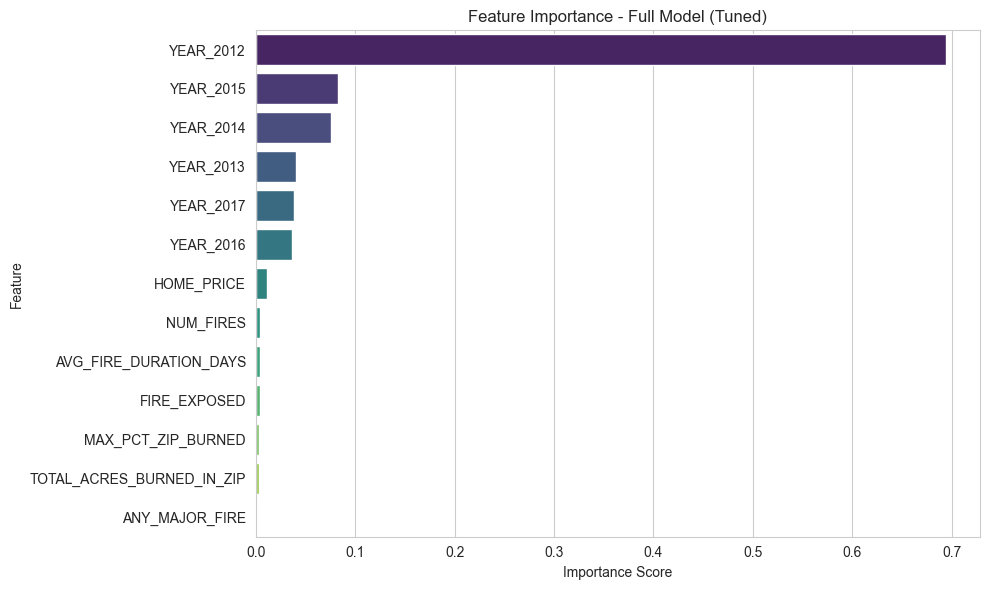


--- 6. Model Comparison (Test Set Performance) ---
Baseline Model R²: -3.9717329045749246
Full Model R²    : -2.82465989998726
------------------------------
Baseline Model RMSE: 9.609614347122394
Full Model RMSE    : 8.428464765291007
------------------------------
Baseline Model MAE : 8.881569363399816
Full Model MAE     : 7.622837737711246


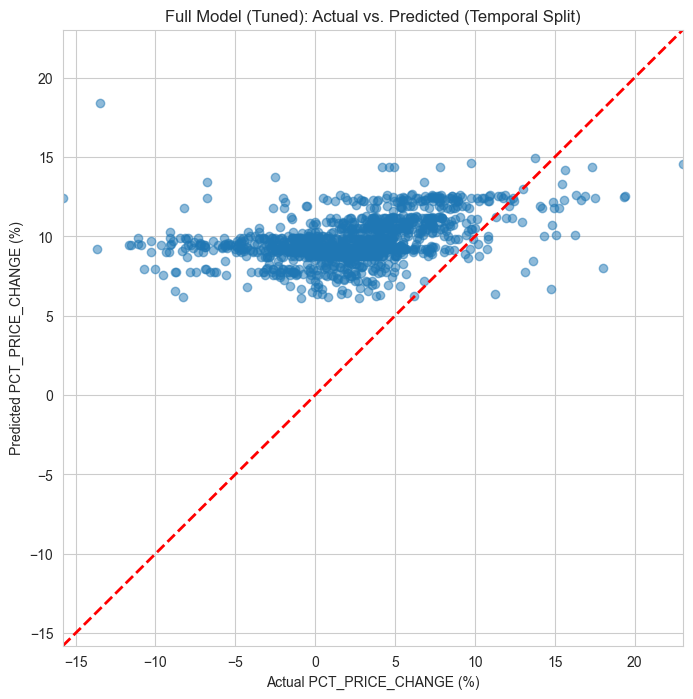


--- Analysis Complete ---


In [ ]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split, RandomizedSearchCV # Keep train_test_split for potential other uses, but we won't use it for the main split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import uniform, randint
import matplotlib.pyplot as plt
import seaborn as sns
import warnings


# --- Configuration ---
TARGET_VARIABLE = 'PCT_PRICE_CHANGE (%)'
RAW_NON_WILDFIRE_FEATURES = ['HOME_PRICE', 'YEAR'] # Essential features for initial dropna
IDENTIFIER_COLUMNS = ['ZipCode'] # Define identifier columns if needed for sorting
WILDFIRE_FEATURES = [
    'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE', 'FIRE_EXPOSED',
]
ALL_RAW_FEATURES = RAW_NON_WILDFIRE_FEATURES + WILDFIRE_FEATURES

CATEGORICAL_FEATURES = ['YEAR'] # Features to be One-Hot Encoded

# --- Temporal Split Configuration ---
SPLIT_YEAR = 2018

# --- Tuning Configuration ---
RANDOM_SEED = 42
N_ITER_TUNING = 50
CV_FOLDS = 5

# --- 1. Load Data ---
print("--- 1. Loading Data ---")
try:
    df = pd.read_csv('xgboost_data.csv')
    print(f"Original data points: {len(df)}")
except FileNotFoundError:
    print("Error: xgboost_data.csv not found. Please ensure the file is in the correct directory.")
    exit()

# --- 2. Data Cleaning & Preprocessing (Strategy: Impute Wildfire NaNs) ---
print("\n--- 2. Data Cleaning & Preprocessing (Strategy: Impute Wildfire NaNs) ---")

# Check if target exists
if TARGET_VARIABLE not in df.columns:
    raise ValueError(f"Target variable '{TARGET_VARIABLE}' not found.")

# Check if all specified raw features exist (including YEAR for split)
all_needed_columns = list(set([TARGET_VARIABLE] + RAW_NON_WILDFIRE_FEATURES + WILDFIRE_FEATURES))
# Add identifier columns if defined
if 'IDENTIFIER_COLUMNS' in locals():
    all_needed_columns = list(set(all_needed_columns + IDENTIFIER_COLUMNS))

missing_columns = [f for f in all_needed_columns if f not in df.columns]
if missing_columns:
     # Check specifically for YEAR as it's critical for splitting
     if 'YEAR' in missing_columns:
         raise ValueError(f"Critical column 'YEAR' is missing. Cannot perform temporal split.")
     raise ValueError(f"Missing essential columns: {missing_columns}")

# --- Step 2a: Drop rows ONLY if TARGET or essential NON-WILDFIRE features are NA ---
critical_cols_for_dropna = [TARGET_VARIABLE] + RAW_NON_WILDFIRE_FEATURES
print(f"Dropping rows with NA in critical columns: {critical_cols_for_dropna}...")
original_count = len(df)
df_cleaned_essential = df.dropna(subset=critical_cols_for_dropna).copy()
dropped_count_essential = original_count - len(df_cleaned_essential)
print(f"Data points after dropping NAs in critical columns: {len(df_cleaned_essential)}")
print(f"Number of rows dropped based on critical columns: {dropped_count_essential}")

if len(df_cleaned_essential) == 0:
    raise ValueError("No data remaining after dropping NAs in target or base features. Check input data quality.")

# --- Step 2b: Impute Wildfire Features with 0 where FIRE_EXPOSED is 0 or NaN ---
# First, ensure FIRE_EXPOSED itself is handled (impute NaN with 0)
if 'FIRE_EXPOSED' in df_cleaned_essential.columns:
    print("Imputing NaN in 'FIRE_EXPOSED' with 0.")
    df_cleaned_essential['FIRE_EXPOSED'] = df_cleaned_essential['FIRE_EXPOSED'].fillna(0).astype(int)
else:
    warnings.warn("'FIRE_EXPOSED' column not found. Cannot use it for conditional imputation. Imputing all wildfire NaNs with 0.")

print("Imputing other wildfire features with 0...")
# Define which features expect NaN->0 imputation
wildfire_cols_to_impute = [
    'NUM_FIRES', 'TOTAL_ACRES_BURNED_IN_ZIP', 'AVG_FIRE_DURATION_DAYS',
    'MAX_PCT_ZIP_BURNED', 'ANY_MAJOR_FIRE' # Exclude FIRE_EXPOSED as it's handled
]

for col in wildfire_cols_to_impute:
    if col in df_cleaned_essential.columns:
        original_nan_count = df_cleaned_essential[col].isna().sum()
        # Impute NaN with 0. This aligns with the description that NaN means no fire.
        df_cleaned_essential[col] = df_cleaned_essential[col].fillna(0)
        # Convert boolean-like columns to int after fillna
        if col in ['ANY_MAJOR_FIRE']:
             try:
                 df_cleaned_essential[col] = df_cleaned_essential[col].astype(int)
             except ValueError:
                 warnings.warn(f"Could not convert column '{col}' to int after imputation.")

        if original_nan_count > 0:
             print(f"  Imputed {original_nan_count} NaNs in '{col}' with 0.")
    else:
        print(f"Warning: Wildfire column '{col}' not found for imputation.")

# Final check for NaNs in the features we plan to use
final_feature_cols = list(set(RAW_NON_WILDFIRE_FEATURES + WILDFIRE_FEATURES))
nan_check = df_cleaned_essential[final_feature_cols].isna().sum()
if nan_check.sum() > 0:
    warnings.warn(f"NaNs still present after imputation in feature columns:\n{nan_check[nan_check > 0]}")
    # Drop any remaining rows with NaN in features
    print("Dropping rows with any remaining NaNs in feature columns...")
    df_clean = df_cleaned_essential.dropna(subset=final_feature_cols).copy()
    print(f"Final data points after all cleaning: {len(df_clean)}")
else:
    df_clean = df_cleaned_essential # Use the imputed data directly
    print(f"Final data points after cleaning/imputation: {len(df_clean)}")


# --- 3. Feature Engineering: One-Hot Encode Categorical Features ---
print("\n--- 3. Feature Engineering: One-Hot Encoding ---")

# Make sure data is sorted by YEAR before creating X and y for splitting
sort_columns = ['YEAR']
if 'ZipCode' in df_clean.columns: # Add ZipCode for stable sort
    sort_columns.append('ZipCode')
df_clean_sorted = df_clean.sort_values(by=sort_columns).reset_index(drop=True) # Reset index for clean slicing later

# Separate target variable and features from the SORTED dataframe
all_input_features = list(set(RAW_NON_WILDFIRE_FEATURES + WILDFIRE_FEATURES))
y = df_clean_sorted[TARGET_VARIABLE]
X_raw = df_clean_sorted[all_input_features] # Features before encoding

# Identify numerical features (those not in CATEGORICAL_FEATURES)
numerical_features = [col for col in all_input_features if col not in CATEGORICAL_FEATURES]
print(f"Numerical features: {numerical_features}")
print(f"Categorical features to encode: {CATEGORICAL_FEATURES}")

# Check unique values in categorical features
for col in CATEGORICAL_FEATURES:
    if col in X_raw.columns:
        n_unique = X_raw[col].nunique()
        print(f"  - Unique values in '{col}': {n_unique}")
        if n_unique > 100: warnings.warn(f"Feature '{col}' high cardinality warning.")
    else: print(f"Warning: Categorical feature '{col}' not found.")


# Apply One-Hot Encoding
if CATEGORICAL_FEATURES and any(col in X_raw.columns for col in CATEGORICAL_FEATURES):
    valid_categorical_features = [col for col in CATEGORICAL_FEATURES if col in X_raw.columns]
    if valid_categorical_features:
        encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
        encoder.fit(X_raw[valid_categorical_features])
        X_encoded_cats = encoder.transform(X_raw[valid_categorical_features])
        encoded_cat_feature_names = encoder.get_feature_names_out(valid_categorical_features)
        X_encoded_df = pd.DataFrame(X_encoded_cats, columns=encoded_cat_feature_names, index=X_raw.index) # Preserve index from X_raw
        valid_numerical_features = [col for col in numerical_features if col in X_raw.columns]
        # Use index alignment during concat
        X_processed = pd.concat([X_raw[valid_numerical_features], X_encoded_df], axis=1)
        print(f"Data shape after encoding: {X_processed.shape}")
        numerical_non_wildfire = [col for col in valid_numerical_features if col in RAW_NON_WILDFIRE_FEATURES]
        categorical_non_wildfire_encoded = [col for col in encoded_cat_feature_names if any(orig_feat in col for orig_feat in valid_categorical_features if orig_feat in RAW_NON_WILDFIRE_FEATURES)]
        final_non_wildfire_features = numerical_non_wildfire + categorical_non_wildfire_encoded
        final_all_features = list(X_processed.columns)
    else:
        print("No valid categorical features found. Using only numerical.")
        X_processed = X_raw[numerical_features].copy()
        final_non_wildfire_features = [col for col in numerical_features if col in RAW_NON_WILDFIRE_FEATURES]
        final_all_features = list(X_processed.columns)
else:
    print("No categorical features specified. Using only numerical.")
    X_processed = X_raw[numerical_features].copy()
    final_non_wildfire_features = [col for col in numerical_features if col in RAW_NON_WILDFIRE_FEATURES]
    final_all_features = list(X_processed.columns)

# --- 4. Split Data (Temporal Split) ---
print("\n--- 4. Splitting Data (Temporal Split) ---")
print(f"Splitting data: Training before year {SPLIT_YEAR}, Testing from year {SPLIT_YEAR} onwards.")

# Ensure X_processed and y indices align with df_clean_sorted['YEAR']
if not X_processed.index.equals(y.index) or not X_processed.index.equals(df_clean_sorted.index):
     raise ValueError("Indices mismatch between X_processed, y, and df_clean_sorted after sorting/processing.")

# Get indices for train and test sets based on YEAR from the sorted DataFrame
train_indices = df_clean_sorted[df_clean_sorted['YEAR'] < SPLIT_YEAR].index
test_indices = df_clean_sorted[df_clean_sorted['YEAR'] >= SPLIT_YEAR].index

if len(train_indices) == 0 or len(test_indices) == 0:
    raise ValueError(f"Could not create non-empty train/test sets with split year {SPLIT_YEAR}. Check YEAR distribution.")

# Create train/test sets using the indices
X_train_full = X_processed.loc[train_indices]
X_test_full = X_processed.loc[test_indices]
y_train = y.loc[train_indices]
y_test = y.loc[test_indices]

# Create the baseline datasets by selecting only the non-wildfire features
# Ensure the feature names are valid *after* OHE
valid_final_non_wildfire_features = [f for f in final_non_wildfire_features if f in X_processed.columns]
X_train_base = X_train_full[valid_final_non_wildfire_features]
X_test_base = X_test_full[valid_final_non_wildfire_features]

print(f"Training data years: {df_clean_sorted.loc[train_indices, 'YEAR'].unique()}")
print(f"Testing data years: {df_clean_sorted.loc[test_indices, 'YEAR'].unique()}")
print(f"Training set size: {len(X_train_base)}")
print(f"Testing set size: {len(X_test_base)}")
print(f"Features in Baseline Model: {len(valid_final_non_wildfire_features)}")
print(f"Features in Full Model: {len(final_all_features)}")

# Check FIRE_EXPOSED distribution in test set
if 'FIRE_EXPOSED' in df_clean_sorted.columns:
    fire_exposed_in_test = df_clean_sorted.loc[test_indices, 'FIRE_EXPOSED'].sum()
    print(f"Percentage FIRE_EXPOSED=1 in Test Set: {100 * fire_exposed_in_test / len(X_test_full):.2f}%")


# --- 5. Model Training, Tuning, and Evaluation ---
def evaluate_model(model_name, y_true, y_pred):
    """Calculates and prints regression metrics."""
    # Add check for empty input
    if len(y_true) == 0 or len(y_pred) == 0:
        print(f"\n{model_name} Performance: Cannot evaluate with empty y_true or y_pred.")
        return {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}
    try:
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)
        print(f"\n{model_name} Performance:")
        print(f"  RMSE: {rmse:.4f}")
        print(f"  MAE:  {mae:.4f}")
        print(f"  R²:   {r2:.4f}")
        return {'RMSE': rmse, 'MAE': mae, 'R2': r2}
    except ValueError as e:
        print(f"\n{model_name} Performance: Error during evaluation - {e}")
        return {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}


def plot_feature_importance(model, feature_names, model_name, top_n=20):
    """Plots feature importance for an XGBoost model with improved readability."""
    if not hasattr(model, 'feature_importances_'):
         print(f"Model {model_name} does not have feature_importances_ attribute. Skipping plot.")
         return
    try:
        importance = model.feature_importances_
        # Ensure feature_names is a list
        if not isinstance(feature_names, list):
            feature_names = list(feature_names)

        if len(importance) != len(feature_names):
             print(f"Warning: Mismatch between number of importances ({len(importance)}) and feature names ({len(feature_names)}) for {model_name}. Plot might be incorrect.")
             # Attempt to align based on minimum length
             min_len = min(len(importance), len(feature_names))
             importance = importance[:min_len]
             feature_names = feature_names[:min_len]
             if min_len == 0:
                 print(f"No features/importances left to plot for {model_name}.")
                 return

        feature_importance = pd.DataFrame({'feature': feature_names, 'importance': importance})
        feature_importance = feature_importance.sort_values('importance', ascending=False)

        # Filter out features with zero importance before selecting top_n
        feature_importance = feature_importance[feature_importance['importance'] > 0]

        if feature_importance.empty:
            print(f"No features with importance > 0 found for {model_name}. Skipping plot.")
            return

        if top_n and top_n < len(feature_importance):
            feature_importance_plot = feature_importance.head(top_n)
            plot_title = f'Top {top_n} Feature Importance - {model_name}'
        else:
             feature_importance_plot = feature_importance
             plot_title = f'Feature Importance - {model_name}'

        sns.set_style("whitegrid")
        plt.figure(figsize=(10, max(6, len(feature_importance_plot) * 0.4)))
        sns.barplot(x='importance', y='feature', data=feature_importance_plot, palette="viridis")
        plt.title(plot_title)
        plt.xlabel("Importance Score")
        plt.ylabel("Feature")
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Error plotting feature importance for {model_name}: {e}")


# --- Hyperparameter Tuning Setup ---
param_dist = {
    'n_estimators': randint(100, 1000),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 11),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'gamma': uniform(0, 0.5),
    'reg_alpha': uniform(0, 1),
    'reg_lambda': uniform(0.5, 4)
}


# --- Baseline Model (Non-Wildfire Features) ---
print("\n--- 5a. Baseline Model (Non-Wildfire Features) ---")
# Check if training data is available
if X_train_base.empty or y_train.empty:
    print("Baseline model training skipped: No training data available after preprocessing/splitting.")
    metrics_base = {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}
else:
    print("Tuning Baseline Model...")

    from sklearn.model_selection import TimeSeriesSplit

    n_splits_cv = CV_FOLDS # Use the configured number of folds
    # Ensure n_splits is feasible given training set size
    if len(X_train_base) < 2 * n_splits_cv: # Basic check, TimeSeriesSplit might need more
        warnings.warn(f"Training set size ({len(X_train_base)}) might be too small for {n_splits_cv} time series splits. Reducing splits.")
        n_splits_cv = max(2, len(X_train_base) // 2) # Adjust to a feasible number

    tscv = TimeSeriesSplit(n_splits=n_splits_cv)

    xgb_base_tune = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED, eval_metric='rmse')
    random_search_base = RandomizedSearchCV(
        estimator=xgb_base_tune, param_distributions=param_dist, n_iter=N_ITER_TUNING,
        cv=tscv, # USE TEMPORAL CV
        scoring='r2', n_jobs=-1, verbose=1, random_state=RANDOM_SEED
    )
    try:
        # Fit on the temporally ordered training data
        random_search_base.fit(X_train_base, y_train)
        print(f"\nBest parameters found for Baseline Model:")
        print(random_search_base.best_params_)
        print(f"Best R² score during TimeSeries CV (Baseline): {random_search_base.best_score_:.4f}")
        best_xgb_base = random_search_base.best_estimator_
        # Predict on the temporally distinct test set
        y_pred_base_tuned = best_xgb_base.predict(X_test_base)
        metrics_base = evaluate_model("Baseline Model (Tuned)", y_test, y_pred_base_tuned)
        # Pass the correct feature names list
        plot_feature_importance(best_xgb_base, valid_final_non_wildfire_features, "Baseline Model (Tuned)", top_n=20)
    except Exception as e: # Catch broader exceptions during fitting/evaluation
         print(f"Error during Baseline Model tuning/evaluation: {e}")
         metrics_base = {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}


# --- Full Model (All Features) ---
print("\n--- 5b. Full Model (All Features) ---")
if X_train_full.empty or y_train.empty:
     print("Full model training skipped: No training data available after preprocessing/splitting.")
     metrics_full = {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}
else:
    print("Tuning Full Model...")
    # Use the same TimeSeriesSplit for fair comparison
    if 'tscv' not in locals(): # Define if not defined during baseline (e.g., if baseline failed)
        n_splits_cv = CV_FOLDS
        if len(X_train_full) < 2 * n_splits_cv:
            n_splits_cv = max(2, len(X_train_full) // 2)
        tscv = TimeSeriesSplit(n_splits=n_splits_cv)

    xgb_full_tune = xgb.XGBRegressor(objective='reg:squarederror', random_state=RANDOM_SEED, eval_metric='rmse')
    random_search_full = RandomizedSearchCV(
        estimator=xgb_full_tune, param_distributions=param_dist, n_iter=N_ITER_TUNING,
        cv=tscv, # USE TEMPORAL CV
        scoring='r2', n_jobs=-1, verbose=1, random_state=RANDOM_SEED
    )
    try:
        # Fit on the temporally ordered training data
        random_search_full.fit(X_train_full, y_train)
        print(f"\nBest parameters found for Full Model:")
        print(random_search_full.best_params_)
        print(f"Best R² score during TimeSeries CV (Full): {random_search_full.best_score_:.4f}")
        best_xgb_full = random_search_full.best_estimator_
        # Predict on the temporally distinct test set
        y_pred_full_tuned = best_xgb_full.predict(X_test_full)
        metrics_full = evaluate_model("Full Model (Tuned)", y_test, y_pred_full_tuned)
        # Pass the correct feature names list
        plot_feature_importance(best_xgb_full, final_all_features, "Full Model (Tuned)", top_n=20)
    except Exception as e: # Catch broader exceptions
        print(f"Error during Full Model tuning/evaluation: {e}")
        metrics_full = {'RMSE': np.nan, 'MAE': np.nan, 'R2': np.nan}


# --- 6. Comparison ---
print("\n--- 6. Model Comparison (Test Set Performance) ---")
# Use .get with a default for safer printing if models failed
print(f"Baseline Model R²: {metrics_base.get('R2', 'N/A')}")
print(f"Full Model R²    : {metrics_full.get('R2', 'N/A')}")
print("-" * 30)
print(f"Baseline Model RMSE: {metrics_base.get('RMSE', 'N/A')}")
print(f"Full Model RMSE    : {metrics_full.get('RMSE', 'N/A')}")
print("-" * 30)
print(f"Baseline Model MAE : {metrics_base.get('MAE', 'N/A')}")
print(f"Full Model MAE     : {metrics_full.get('MAE', 'N/A')}")

# Optional: Plot Predicted vs Actual only if full model ran successfully
if 'y_pred_full_tuned' in locals() and not y_test.empty:
    plt.figure(figsize=(8, 8))
    plt.scatter(y_test, y_pred_full_tuned, alpha=0.5)
    # Add ideal line based on test set range for better visualization
    min_val = min(y_test.min(), y_pred_full_tuned.min())
    max_val = max(y_test.max(), y_pred_full_tuned.max())
    plt.plot([min_val, max_val], [min_val, max_val], '--r', linewidth=2)
    plt.title('Full Model (Tuned): Actual vs. Predicted (Temporal Split)')
    plt.xlabel(f'Actual {TARGET_VARIABLE}')
    plt.ylabel(f'Predicted {TARGET_VARIABLE}')
    plt.grid(True)
    plt.xlim(min_val, max_val) # Adjust limits for better view
    plt.ylim(min_val, max_val)
    plt.show()
else:
    print("\nSkipping Actual vs Predicted plot as full model results are unavailable.")

print("\n--- Analysis Complete ---")